# Bottlenecks

**Konrad Lohse and Jerome Kelleher**

The site frequency spectrum (SFS) summarises variants by their frequency in a sample and is a fundamental summary of sequence variation that forms the basis of many modern inference approaches (e.g. sweepfinder, DFE-alpha, dadi). First, the SFS is a lossless summary of unlinked variants, so any summary of sequence variation that ignores linkage (e.g. pairwise measures of diversity and divergence, F_st, Tajima's D and D) are summaries of the SFS.

The SFS is convenient analytically, because it only depends on the mean length and frequency of genealogical branches. For many demographic models of interest the means can be derived analytically either using coalescent theory (cite Huang, TPB) or diffusion equations (cite dadi). A number of composite likelihood approaches have been developed based on either analytic results for the SFS (cite dadi Excoffier, Jaada). However, analytic expectations for the SFS break down for large samples and/or complex demographic models. 

In the following section we show how the SFS can be approximated using coalescence simulations and compare such approximations to analytic results. We will assume a simple toy history of a single panmictic population that is affected by an instaneous bottleneck at time T with strenght s (cite Galtier et al). The effect of this bottleneck is to induce sudden burst of coalescence, which simultaneous multiple merges. We measure bottleneck strength as the probability that a pair of lineages coalesces during the bottleneck (we could could of course convert s into on (imaginary) time period that would give the same probability of coalescence $s=1-e^{-T}$).

We assume a sample of size 10 and use msprime to simulate 10,000 replicate genealogies. For each genealogy the function bottSFS records the unfolded SFS as the mean length of branches with n leafnodes (normalized by the total length of the genealogy) by iterating through all nodes in the tree.sequence. Note that we are simulating genealogies only, i.e. we do not need to simulate mutations.

We use a for loop to record the SFS for a range of bottleneck strengths parameters in a dictionary:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def run_bott_sims(num_rep, num_samp, T, s):    
    demographic_events = [
        msprime.InstantaneousBottleneck(time=T, strength=s, population=0)]
    reps = msprime.simulate(
        sample_size=num_samp, Ne=Ne, num_replicates=num_rep, 
        demographic_events=demographic_events)
    return reps

def approx_SFS(reps):
    B = np.zeros((num_rep, num_samp))
    for rep_index, ts in enumerate(reps):
        assert ts.num_trees == 1
        tree = ts.first()
        for u in tree.nodes():
            nleaves = tree.num_samples(u)
            if tree.parent(u) != msprime.NULL_NODE:
                B[rep_index, nleaves] += tree.branch_length(u)    
    data = np.mean(B, axis=0)
    data /= np.sum(data)
    return data

num_rep = 1000
num_samp = 10
Ne = 1
T = 0.5
taulist= np.array([0,1,2,3])
datalist = {}
for tau in taulist:
    datalist[tau]= approx_SFS(run_bott_sims(num_rep, num_samp, T, tau))
    
# My guess/assumption is that currently bottleneck strength in msprime is scaled as an (imaginary) time tau (in units of 4N_e) generations. 
# It makes a lot more sense to express the bottleneck strength as the probability of pairwise coalescence
# during the bottelenck s=1-np.exp(-tau/2)

With increasing bottleneck strength the SFS becomes increasingly skewed (the leftmost blue bars show the SFS for a population of constant size). However, bottlenecks have a complex effect on the different frequency classes of the SFS: while the relative frequency of singletons increases, other frequency classes (e.g. doubletons) have a non-monotonic relationship with bottleneck strength:

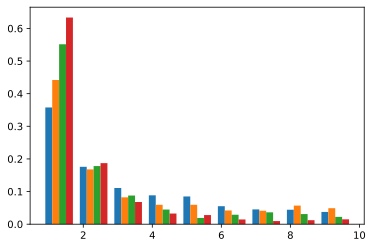

In [3]:
bar_width=0.2
index = np.arange(1,num_samp)
j = 0
for s, B in datalist.items():
    plt.bar(index + j * bar_width, B[1:], bar_width, label=str(s))
    j += 1

## Comparison with analytic predictions

How does the approximate SFS compare to analytic expectations? For a population of constant size, the SFS is simply given by Watterson's correction factor, that is the total length branches with i leafnodes is given is 1/i. Reassuringly, in the limit of s=0 (no bottleneck), our SFS approximation based on simulated genealogies agrees with this prediction:

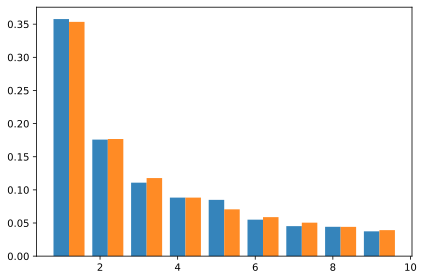

In [4]:
expsfs=[(1/i) for i in range(1,10)]
expsfs/=np.sum(expsfs)

fig, ax = plt.subplots()
index = np.arange(1,10)
bar_width = 0.4
opacity = 0.9

simsfs = ax.bar(index, datalist[0][1:], bar_width, alpha=opacity, label='sim')
expextsfs = ax.bar(index+ bar_width, expsfs, bar_width, alpha=opacity, label='exp')

fig.tight_layout()
plt.show()

The analytic prediction for the SFS under a bottleneck model is more complicated (Bunnefeld et al. 2015, Appendix). For a sample of n=4 lineages the SFS is:

In [5]:
#We are assuming a bottleneck of strength tau = 4 N_e generations 
#and a bottleneck time of T=1 (2 in units of 4 Ne)
#I am pretty sure the analytic prediction for the SFS is correct: the limit mfor s->0 is correct and
#itr matches the automatically generated expression in the Mathematica .nb...

T=2
slist=[1-np.exp(-tau) for tau in taulist]

for s in slist:
    p=s*(-6 + 15*s - 20 * np.power(s,2) + 15 * np.power(s,3) - 6 * np.power(s,4) + np.power(s,5))
    expsfsBottlN= [2/15*(np.exp(-6*T)*(15 *np.exp(6*T) - 9 *np.exp(5*T)*s - 
                                   5*np.exp(3*T)*s*(3 - 3*s + np.power(s,2)) + p)),
               1/5*np.exp(-6*T)*(5*np.exp(6*T) - 6*np.exp(5*T)*s - p),
               2/15*np.exp(-6*T)*(5*np.exp(6*T) - 9*np.exp(5*T)*s + 5*np.exp(3*T)*s*(3-3*s + np.power(s,2)) + p)]

    expsfsBottlN/=np.sum(expsfsBottlN)
    print(expsfsBottlN)

[0.54545455 0.27272727 0.18181818]
[0.5644372  0.26717043 0.16839237]
[0.57248098 0.26486068 0.16265835]
[0.57559102 0.26396986 0.16043912]


The fit between the SFS simulated with msprime and the analytic prediction is noty convincing (given the 100,000 replicates):

In [6]:
num_samp = 4
num_rep = 1000
data4 = {}
T = 1
for tau in taulist:
    data4[tau]= approx_SFS(run_bott_sims(num_rep, num_samp, T, tau/2))

[0.53662528 0.2904602  0.17291451]
[0.56727819 0.25025608 0.18246572]
[0.61420568 0.23147665 0.15431767]
[0.65494154 0.22949303 0.11556544]


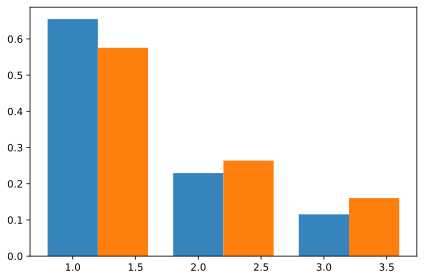

In [7]:
fig, ax = plt.subplots()
index = np.arange(1,4)
bar_width = 0.4
print(data4[0][1:])
print(data4[1][1:])
print(data4[2][1:])
print(data4[3][1:])

simsfs = ax.bar(index, data4[3][1:], bar_width, alpha=opacity, label='sim')
expextsfs = ax.bar(index+ bar_width, expsfsBottlN, bar_width, label='exp')

fig.tight_layout()
plt.show()

## The distribution of nton branches

Given that the SFS only depends on mean  branch lengths, it is interesting to inspect the probability density distribution of the underlying genealogical branches. Given the discrete event, the pfd of nton branches are discontinuous.

In [8]:
s=1
demographic_events = [msprime.InstantaneousBottleneck(time=T, strength=s, population=0)]
reps = msprime.simulate(
    sample_size=num_samp, Ne=Ne, num_replicates=num_rep, 
    demographic_events=demographic_events)
B = np.zeros((num_rep, num_samp))
for rep_index, ts in enumerate(reps):
    tree = next(ts.trees())
    for u in tree.nodes():
        nleaves = tree.num_samples(u)
        if tree.parent(u) != msprime.NULL_NODE:
            B[rep_index, nleaves]+=tree.branch_length(u)

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

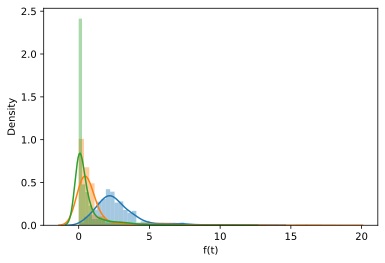

In [9]:
Btrans=np.array(B).T.tolist()
sns.distplot(Btrans[1],axlabel="f(t)")
sns.distplot(Btrans[2],axlabel="f(t)")
sns.distplot(Btrans[3],axlabel="f(t)");

### To Do

1) Fix the scaling of the strength in msprime
2) Fix the pdf plot above: 
    - Label axes on the pdf plot above: y-> f(t), x -> t
    - Restrict X range to 15
3) Fix the x axes on all the barplots so that these correspond to classes in the SFS